## Exercise 4: Regression problem using an RBF model
### Georgios Tsoumplekas
### AEM: 9359

### Imports

In [1]:
import tensorflow as tf

from tensorflow.keras.datasets import boston_housing
from tensorflow.keras import models,layers
from tensorflow.keras import initializers
from tensorflow.keras import backend as K

import keras_tuner as kt

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise
from sklearn.model_selection import KFold

from scipy.spatial import distance_matrix
from scipy.spatial.distance import pdist

import numpy as np

import matplotlib.pyplot as plt

### Preprocessing of the Boston housing dataset

In [2]:
#Load dataset
(x_train, y_train), (x_test, y_test) = boston_housing.load_data(test_split=0.25)

print("x_train shape", x_train.shape) 
print("y_train shape", y_train.shape)
print("x_test shape", x_test.shape)
print("y_test shape", y_test.shape)

#Convert to float32
x_train, x_test = np.array(x_train, dtype=np.float32), np.array(x_test, dtype=np.float32)

#Normalize each feature to [0,1]
x_train_max, x_test_max = np.amax(x_train, axis=0), np.amax(x_test, axis=0)
x_train_min, x_test_min = np.amin(x_train, axis=0), np.amin(x_test, axis=0)

x_train, x_test = (x_train-x_train_min)/(x_train_max-x_train_min), (x_test-x_test_min)/(x_test_max-x_test_min)

x_train shape (379, 13)
y_train shape (379,)
x_test shape (127, 13)
y_test shape (127,)


## Part 1: Simple RBF application

### Custom made function that calculates R squared index

In [3]:
def R2(y_true, y_pred):
    SS_res = K.sum(K.square(y_true-y_pred))
    SS_tot = K.sum(K.square(y_true-K.mean(y_true)))
    return (1 - SS_res/(SS_tot+K.epsilon()))

### Model 1: Number of kernels = 0.1 * number of training samples

### Calculate the centers and variance for the kernels using the K-Means algorithm

In [4]:
# Number of kernels in hidden layer
num_centers = int(0.1*x_train.shape[0])

# Centers of the kernels
kmeans = KMeans(n_clusters=num_centers, init='k-means++', n_init=10, verbose=0).fit(x_train)
centers = kmeans.cluster_centers_

# Variance of each kernel
dists = pdist(centers, metric='euclidean')
d_max = np.amax(dists)
var = d_max / tf.math.sqrt(2*float(centers.shape[0]))

# Pass training data through the kernels
x = pairwise.rbf_kernel(x_train, Y=centers, gamma=np.float32(1/(2*var)))

### Create the output layer

In [5]:
# The model contains the output layer and its input is the output of the hidden layer
model_1 = models.Sequential()

# Output layer
model_1.add(layers.Dense(128, activation='relu', input_shape=(x.shape[1],),
                         kernel_initializer=initializers.LecunNormal()))

model_1.add(layers.Dense(1, activation='relu',
                         kernel_initializer=initializers.LecunNormal()))

model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               4864      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 4,993
Trainable params: 4,993
Non-trainable params: 0
_________________________________________________________________


### Train the model

Epoch 1/400
5/5 [==============================] - 1s 62ms/step - loss: 529.4210 - root_mean_squared_error: 23.0092 - R2: -6.1085 - val_loss: 708.2217 - val_root_mean_squared_error: 26.6124 - val_R2: -8.4200
Epoch 2/400
5/5 [==============================] - 0s 9ms/step - loss: 476.3023 - root_mean_squared_error: 21.8244 - R2: -6.0108 - val_loss: 637.3040 - val_root_mean_squared_error: 25.2449 - val_R2: -7.2306
Epoch 3/400
5/5 [==============================] - 0s 10ms/step - loss: 410.0374 - root_mean_squared_error: 20.2494 - R2: -4.5743 - val_loss: 545.8470 - val_root_mean_squared_error: 23.3634 - val_R2: -5.7122
Epoch 4/400
5/5 [==============================] - 0s 12ms/step - loss: 328.1176 - root_mean_squared_error: 18.1140 - R2: -3.4422 - val_loss: 440.2174 - val_root_mean_squared_error: 20.9814 - val_R2: -3.9959
Epoch 5/400
5/5 [==============================] - 0s 15ms/step - loss: 243.0171 - root_mean_squared_error: 15.5890 - R2: -2.1390 - val_loss: 343.3484 - val_root_mean_sq

Epoch 41/400
5/5 [==============================] - 0s 9ms/step - loss: 56.0816 - root_mean_squared_error: 7.4888 - R2: 0.2608 - val_loss: 136.6884 - val_root_mean_squared_error: 11.6914 - val_R2: -0.1933
Epoch 42/400
5/5 [==============================] - 0s 10ms/step - loss: 55.4723 - root_mean_squared_error: 7.4480 - R2: 0.3106 - val_loss: 136.1780 - val_root_mean_squared_error: 11.6695 - val_R2: -0.1861
Epoch 43/400
5/5 [==============================] - 0s 12ms/step - loss: 54.8630 - root_mean_squared_error: 7.4070 - R2: 0.2813 - val_loss: 135.1313 - val_root_mean_squared_error: 11.6246 - val_R2: -0.1776
Epoch 44/400
5/5 [==============================] - 0s 15ms/step - loss: 54.4731 - root_mean_squared_error: 7.3806 - R2: 0.3039 - val_loss: 133.8728 - val_root_mean_squared_error: 11.5703 - val_R2: -0.1685
Epoch 45/400
5/5 [==============================] - 0s 12ms/step - loss: 53.8309 - root_mean_squared_error: 7.3370 - R2: 0.3054 - val_loss: 132.4791 - val_root_mean_squared_erro

Epoch 81/400
5/5 [==============================] - 0s 10ms/step - loss: 40.7599 - root_mean_squared_error: 6.3843 - R2: 0.4532 - val_loss: 103.1534 - val_root_mean_squared_error: 10.1564 - val_R2: 0.0878
Epoch 82/400
5/5 [==============================] - 0s 9ms/step - loss: 40.2667 - root_mean_squared_error: 6.3456 - R2: 0.4973 - val_loss: 101.9752 - val_root_mean_squared_error: 10.0983 - val_R2: 0.0934
Epoch 83/400
5/5 [==============================] - 0s 11ms/step - loss: 40.0364 - root_mean_squared_error: 6.3274 - R2: 0.4917 - val_loss: 101.5857 - val_root_mean_squared_error: 10.0790 - val_R2: 0.0979
Epoch 84/400
5/5 [==============================] - 0s 14ms/step - loss: 39.7922 - root_mean_squared_error: 6.3081 - R2: 0.4901 - val_loss: 101.1254 - val_root_mean_squared_error: 10.0561 - val_R2: 0.1025
Epoch 85/400
5/5 [==============================] - 0s 17ms/step - loss: 39.5696 - root_mean_squared_error: 6.2904 - R2: 0.4932 - val_loss: 100.5990 - val_root_mean_squared_error: 1

5/5 [==============================] - 0s 9ms/step - loss: 33.5875 - root_mean_squared_error: 5.7955 - R2: 0.5703 - val_loss: 83.6800 - val_root_mean_squared_error: 9.1477 - val_R2: 0.2504
Epoch 122/400
5/5 [==============================] - 0s 9ms/step - loss: 33.4518 - root_mean_squared_error: 5.7838 - R2: 0.5351 - val_loss: 83.8718 - val_root_mean_squared_error: 9.1582 - val_R2: 0.2535
Epoch 123/400
5/5 [==============================] - 0s 9ms/step - loss: 33.3056 - root_mean_squared_error: 5.7711 - R2: 0.5585 - val_loss: 82.9968 - val_root_mean_squared_error: 9.1103 - val_R2: 0.2572
Epoch 124/400
5/5 [==============================] - 0s 8ms/step - loss: 33.1666 - root_mean_squared_error: 5.7590 - R2: 0.5694 - val_loss: 82.2536 - val_root_mean_squared_error: 9.0694 - val_R2: 0.2597
Epoch 125/400
5/5 [==============================] - 0s 9ms/step - loss: 33.1079 - root_mean_squared_error: 5.7539 - R2: 0.5945 - val_loss: 82.3906 - val_root_mean_squared_error: 9.0769 - val_R2: 0.2631

5/5 [==============================] - 0s 10ms/step - loss: 29.3624 - root_mean_squared_error: 5.4187 - R2: 0.6367 - val_loss: 71.8755 - val_root_mean_squared_error: 8.4779 - val_R2: 0.3544
Epoch 162/400
5/5 [==============================] - 0s 16ms/step - loss: 29.1539 - root_mean_squared_error: 5.3994 - R2: 0.6069 - val_loss: 71.3442 - val_root_mean_squared_error: 8.4465 - val_R2: 0.3558
Epoch 163/400
5/5 [==============================] - 0s 17ms/step - loss: 29.0691 - root_mean_squared_error: 5.3916 - R2: 0.6300 - val_loss: 71.3553 - val_root_mean_squared_error: 8.4472 - val_R2: 0.3586
Epoch 164/400
5/5 [==============================] - 0s 17ms/step - loss: 28.9823 - root_mean_squared_error: 5.3835 - R2: 0.6216 - val_loss: 71.2766 - val_root_mean_squared_error: 8.4425 - val_R2: 0.3612
Epoch 165/400
5/5 [==============================] - 0s 13ms/step - loss: 28.9149 - root_mean_squared_error: 5.3773 - R2: 0.6063 - val_loss: 70.8767 - val_root_mean_squared_error: 8.4188 - val_R2: 0

5/5 [==============================] - 0s 9ms/step - loss: 25.9700 - root_mean_squared_error: 5.0961 - R2: 0.6574 - val_loss: 63.5819 - val_root_mean_squared_error: 7.9738 - val_R2: 0.4294
Epoch 202/400
5/5 [==============================] - 0s 10ms/step - loss: 25.8777 - root_mean_squared_error: 5.0870 - R2: 0.6723 - val_loss: 63.3343 - val_root_mean_squared_error: 7.9583 - val_R2: 0.4310
Epoch 203/400
5/5 [==============================] - 0s 9ms/step - loss: 25.8320 - root_mean_squared_error: 5.0825 - R2: 0.6771 - val_loss: 62.8305 - val_root_mean_squared_error: 7.9266 - val_R2: 0.4326
Epoch 204/400
5/5 [==============================] - 0s 9ms/step - loss: 25.7250 - root_mean_squared_error: 5.0720 - R2: 0.7013 - val_loss: 63.0363 - val_root_mean_squared_error: 7.9395 - val_R2: 0.4347
Epoch 205/400
5/5 [==============================] - 0s 8ms/step - loss: 25.6685 - root_mean_squared_error: 5.0664 - R2: 0.6681 - val_loss: 62.6218 - val_root_mean_squared_error: 7.9134 - val_R2: 0.435

5/5 [==============================] - 0s 9ms/step - loss: 23.4623 - root_mean_squared_error: 4.8438 - R2: 0.6989 - val_loss: 57.1551 - val_root_mean_squared_error: 7.5601 - val_R2: 0.4875
Epoch 242/400
5/5 [==============================] - 0s 8ms/step - loss: 23.4985 - root_mean_squared_error: 4.8475 - R2: 0.6909 - val_loss: 57.1095 - val_root_mean_squared_error: 7.5571 - val_R2: 0.4893
Epoch 243/400
5/5 [==============================] - 0s 9ms/step - loss: 23.4151 - root_mean_squared_error: 4.8389 - R2: 0.6958 - val_loss: 56.6562 - val_root_mean_squared_error: 7.5270 - val_R2: 0.4904
Epoch 244/400
5/5 [==============================] - 0s 9ms/step - loss: 23.3415 - root_mean_squared_error: 4.8313 - R2: 0.7077 - val_loss: 56.5496 - val_root_mean_squared_error: 7.5199 - val_R2: 0.4915
Epoch 245/400
5/5 [==============================] - 0s 9ms/step - loss: 23.2743 - root_mean_squared_error: 4.8243 - R2: 0.7212 - val_loss: 56.3361 - val_root_mean_squared_error: 7.5057 - val_R2: 0.4922

5/5 [==============================] - 0s 8ms/step - loss: 21.5358 - root_mean_squared_error: 4.6407 - R2: 0.7310 - val_loss: 52.4140 - val_root_mean_squared_error: 7.2398 - val_R2: 0.5358
Epoch 282/400
5/5 [==============================] - 0s 9ms/step - loss: 21.3807 - root_mean_squared_error: 4.6239 - R2: 0.7203 - val_loss: 52.0078 - val_root_mean_squared_error: 7.2116 - val_R2: 0.5366
Epoch 283/400
5/5 [==============================] - 0s 9ms/step - loss: 21.3767 - root_mean_squared_error: 4.6235 - R2: 0.7292 - val_loss: 52.0769 - val_root_mean_squared_error: 7.2164 - val_R2: 0.5372
Epoch 284/400
5/5 [==============================] - 0s 9ms/step - loss: 21.3106 - root_mean_squared_error: 4.6163 - R2: 0.7287 - val_loss: 51.9058 - val_root_mean_squared_error: 7.2046 - val_R2: 0.5376
Epoch 285/400
5/5 [==============================] - 0s 9ms/step - loss: 21.2655 - root_mean_squared_error: 4.6114 - R2: 0.7217 - val_loss: 51.8860 - val_root_mean_squared_error: 7.2032 - val_R2: 0.5386

5/5 [==============================] - 0s 9ms/step - loss: 19.8828 - root_mean_squared_error: 4.4590 - R2: 0.7335 - val_loss: 48.8819 - val_root_mean_squared_error: 6.9916 - val_R2: 0.5711
Epoch 322/400
5/5 [==============================] - 0s 9ms/step - loss: 19.8543 - root_mean_squared_error: 4.4558 - R2: 0.7431 - val_loss: 48.3107 - val_root_mean_squared_error: 6.9506 - val_R2: 0.5708
Epoch 323/400
5/5 [==============================] - 0s 9ms/step - loss: 19.9743 - root_mean_squared_error: 4.4693 - R2: 0.7154 - val_loss: 48.5954 - val_root_mean_squared_error: 6.9710 - val_R2: 0.5730
Epoch 324/400
5/5 [==============================] - 0s 10ms/step - loss: 19.8298 - root_mean_squared_error: 4.4531 - R2: 0.7394 - val_loss: 48.4286 - val_root_mean_squared_error: 6.9591 - val_R2: 0.5749
Epoch 325/400
5/5 [==============================] - 0s 8ms/step - loss: 19.7676 - root_mean_squared_error: 4.4461 - R2: 0.7352 - val_loss: 48.4341 - val_root_mean_squared_error: 6.9595 - val_R2: 0.576

5/5 [==============================] - 0s 9ms/step - loss: 18.6931 - root_mean_squared_error: 4.3236 - R2: 0.7475 - val_loss: 45.3812 - val_root_mean_squared_error: 6.7366 - val_R2: 0.6000
Epoch 362/400
5/5 [==============================] - 0s 9ms/step - loss: 18.7358 - root_mean_squared_error: 4.3285 - R2: 0.7563 - val_loss: 45.3982 - val_root_mean_squared_error: 6.7378 - val_R2: 0.6012
Epoch 363/400
5/5 [==============================] - 0s 10ms/step - loss: 18.6634 - root_mean_squared_error: 4.3201 - R2: 0.7661 - val_loss: 45.6213 - val_root_mean_squared_error: 6.7544 - val_R2: 0.6020
Epoch 364/400
5/5 [==============================] - 0s 9ms/step - loss: 18.5576 - root_mean_squared_error: 4.3078 - R2: 0.7543 - val_loss: 45.5793 - val_root_mean_squared_error: 6.7512 - val_R2: 0.6026
Epoch 365/400
5/5 [==============================] - 0s 9ms/step - loss: 18.5593 - root_mean_squared_error: 4.3080 - R2: 0.7618 - val_loss: 45.4410 - val_root_mean_squared_error: 6.7410 - val_R2: 0.602

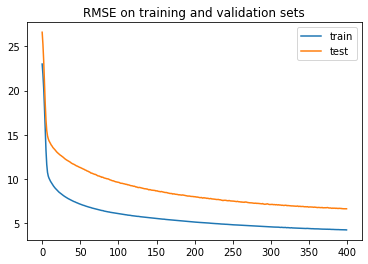

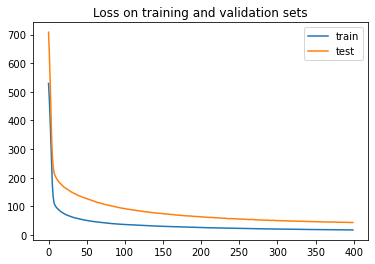

In [6]:
# Build model
model_1.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.001),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics = [tf.keras.metrics.RootMeanSquaredError(), R2])

# Train model
history = model_1.fit(x, y_train, epochs=400, batch_size=64, validation_split=0.2, verbose=1)

# Plot RMSE
plt.figure(1)
plt.plot(history.history['root_mean_squared_error'],label='train')
plt.plot(history.history['val_root_mean_squared_error'],label='test')
plt.legend()
plt.title('RMSE on training and validation sets')
plt.show()

# Plot MSE
plt.figure(2)
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.title('Loss on training and validation sets')
plt.show()

### Predict with the model

In [7]:
# Pass test data through the kernels
x = pairwise.rbf_kernel(x_test, Y=centers, gamma=np.float32(1/(2*var)))

# Metrics for the test set
scores = model_1.evaluate(x,y_test, verbose=0)

print('For the test set:')
print('R2: {}'.format(scores[2]))
print('RMSE: {}'.format(scores[1]))

For the test set:
R2: 0.5673857927322388
RMSE: 5.628942489624023


### Model 2: Number of kernels = 0.5 * number of training samples

### Calculate the centers and variance for the kernels using the K-Means algorithm

In [8]:
# Number of kernels in hidden layer
num_centers = int(0.5*x_train.shape[0])

# Centers of the kernels
kmeans = KMeans(n_clusters=num_centers, init='k-means++', n_init=10, verbose=0).fit(x_train)
centers = kmeans.cluster_centers_

# Variance of each kernel
dists = pdist(centers, metric='euclidean')
d_max = np.amax(dists)
var = d_max / tf.math.sqrt(2*float(centers.shape[0]))

# Pass training data through the kernels
x = pairwise.rbf_kernel(x_train, Y=centers, gamma=np.float32(1/(2*var)))

### Create the output layer

In [9]:
# The model contains the output layer and its input is the output of the hidden layer
model_2 = models.Sequential()

# Output layer
model_2.add(layers.Dense(128, activation='relu', input_shape=(x.shape[1],),
                         kernel_initializer=initializers.LecunNormal()))

model_2.add(layers.Dense(1, activation='relu',
                         kernel_initializer=initializers.LecunNormal()))

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 128)               24320     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 24,449
Trainable params: 24,449
Non-trainable params: 0
_________________________________________________________________


### Train the model

Epoch 1/400
5/5 [==============================] - 0s 42ms/step - loss: 531.9397 - root_mean_squared_error: 23.0638 - R2: -6.2771 - val_loss: 718.9728 - val_root_mean_squared_error: 26.8137 - val_R2: -8.6037
Epoch 2/400
5/5 [==============================] - 0s 11ms/step - loss: 489.3598 - root_mean_squared_error: 22.1215 - R2: -5.5794 - val_loss: 657.1631 - val_root_mean_squared_error: 25.6352 - val_R2: -7.5628
Epoch 3/400
5/5 [==============================] - 0s 12ms/step - loss: 428.3452 - root_mean_squared_error: 20.6965 - R2: -4.5718 - val_loss: 566.4045 - val_root_mean_squared_error: 23.7993 - val_R2: -6.0372
Epoch 4/400
5/5 [==============================] - 0s 12ms/step - loss: 344.2548 - root_mean_squared_error: 18.5541 - R2: -3.6576 - val_loss: 454.0646 - val_root_mean_squared_error: 21.3088 - val_R2: -4.1851
Epoch 5/400
5/5 [==============================] - 0s 10ms/step - loss: 253.2943 - root_mean_squared_error: 15.9152 - R2: -2.3700 - val_loss: 352.4069 - val_root_mean_s

Epoch 41/400
5/5 [==============================] - 0s 9ms/step - loss: 41.3366 - root_mean_squared_error: 6.4294 - R2: 0.4800 - val_loss: 111.7914 - val_root_mean_squared_error: 10.5731 - val_R2: 0.0991
Epoch 42/400
5/5 [==============================] - 0s 9ms/step - loss: 40.8705 - root_mean_squared_error: 6.3930 - R2: 0.4573 - val_loss: 110.0598 - val_root_mean_squared_error: 10.4909 - val_R2: 0.1160
Epoch 43/400
5/5 [==============================] - 0s 10ms/step - loss: 40.3025 - root_mean_squared_error: 6.3484 - R2: 0.4584 - val_loss: 109.1295 - val_root_mean_squared_error: 10.4465 - val_R2: 0.1319
Epoch 44/400
5/5 [==============================] - 0s 9ms/step - loss: 39.5267 - root_mean_squared_error: 6.2870 - R2: 0.5177 - val_loss: 107.3883 - val_root_mean_squared_error: 10.3628 - val_R2: 0.1447
Epoch 45/400
5/5 [==============================] - 0s 9ms/step - loss: 39.0420 - root_mean_squared_error: 6.2484 - R2: 0.5382 - val_loss: 106.8234 - val_root_mean_squared_error: 10.3

5/5 [==============================] - 0s 9ms/step - loss: 27.3409 - root_mean_squared_error: 5.2288 - R2: 0.6504 - val_loss: 77.6800 - val_root_mean_squared_error: 8.8136 - val_R2: 0.4300
Epoch 82/400
5/5 [==============================] - 0s 11ms/step - loss: 27.1926 - root_mean_squared_error: 5.2147 - R2: 0.6483 - val_loss: 76.9251 - val_root_mean_squared_error: 8.7707 - val_R2: 0.4324
Epoch 83/400
5/5 [==============================] - 0s 8ms/step - loss: 27.0715 - root_mean_squared_error: 5.2030 - R2: 0.6394 - val_loss: 76.3028 - val_root_mean_squared_error: 8.7351 - val_R2: 0.4352
Epoch 84/400
5/5 [==============================] - 0s 9ms/step - loss: 26.8589 - root_mean_squared_error: 5.1826 - R2: 0.6496 - val_loss: 75.6800 - val_root_mean_squared_error: 8.6994 - val_R2: 0.4361
Epoch 85/400
5/5 [==============================] - 0s 8ms/step - loss: 26.7335 - root_mean_squared_error: 5.1704 - R2: 0.6596 - val_loss: 76.0113 - val_root_mean_squared_error: 8.7184 - val_R2: 0.4446
Ep

5/5 [==============================] - 0s 11ms/step - loss: 22.3185 - root_mean_squared_error: 4.7242 - R2: 0.7130 - val_loss: 65.0708 - val_root_mean_squared_error: 8.0666 - val_R2: 0.5345
Epoch 122/400
5/5 [==============================] - 0s 10ms/step - loss: 22.0977 - root_mean_squared_error: 4.7008 - R2: 0.7142 - val_loss: 64.8132 - val_root_mean_squared_error: 8.0507 - val_R2: 0.5373
Epoch 123/400
5/5 [==============================] - 0s 11ms/step - loss: 22.0714 - root_mean_squared_error: 4.6980 - R2: 0.7047 - val_loss: 64.3426 - val_root_mean_squared_error: 8.0214 - val_R2: 0.5379
Epoch 124/400
5/5 [==============================] - 0s 11ms/step - loss: 21.9474 - root_mean_squared_error: 4.6848 - R2: 0.7236 - val_loss: 64.4553 - val_root_mean_squared_error: 8.0284 - val_R2: 0.5406
Epoch 125/400
5/5 [==============================] - 0s 9ms/step - loss: 21.8151 - root_mean_squared_error: 4.6707 - R2: 0.7168 - val_loss: 64.1850 - val_root_mean_squared_error: 8.0116 - val_R2: 0.

5/5 [==============================] - 0s 10ms/step - loss: 18.9661 - root_mean_squared_error: 4.3550 - R2: 0.7566 - val_loss: 58.2098 - val_root_mean_squared_error: 7.6295 - val_R2: 0.5922
Epoch 162/400
5/5 [==============================] - 0s 8ms/step - loss: 18.8781 - root_mean_squared_error: 4.3449 - R2: 0.7599 - val_loss: 57.8649 - val_root_mean_squared_error: 7.6069 - val_R2: 0.5916
Epoch 163/400
5/5 [==============================] - 0s 9ms/step - loss: 18.7968 - root_mean_squared_error: 4.3355 - R2: 0.7528 - val_loss: 58.0201 - val_root_mean_squared_error: 7.6171 - val_R2: 0.5951
Epoch 164/400
5/5 [==============================] - 0s 8ms/step - loss: 18.7713 - root_mean_squared_error: 4.3326 - R2: 0.7392 - val_loss: 57.7596 - val_root_mean_squared_error: 7.6000 - val_R2: 0.5963
Epoch 165/400
5/5 [==============================] - 0s 9ms/step - loss: 18.6615 - root_mean_squared_error: 4.3199 - R2: 0.7625 - val_loss: 58.0999 - val_root_mean_squared_error: 7.6223 - val_R2: 0.597

5/5 [==============================] - 0s 9ms/step - loss: 16.4774 - root_mean_squared_error: 4.0592 - R2: 0.7935 - val_loss: 53.1126 - val_root_mean_squared_error: 7.2878 - val_R2: 0.6295
Epoch 202/400
5/5 [==============================] - 0s 10ms/step - loss: 16.4998 - root_mean_squared_error: 4.0620 - R2: 0.7795 - val_loss: 53.1723 - val_root_mean_squared_error: 7.2919 - val_R2: 0.6311
Epoch 203/400
5/5 [==============================] - 0s 9ms/step - loss: 16.3661 - root_mean_squared_error: 4.0455 - R2: 0.7950 - val_loss: 52.8210 - val_root_mean_squared_error: 7.2678 - val_R2: 0.6318
Epoch 204/400
5/5 [==============================] - 0s 10ms/step - loss: 16.2880 - root_mean_squared_error: 4.0358 - R2: 0.7993 - val_loss: 52.9004 - val_root_mean_squared_error: 7.2733 - val_R2: 0.6326
Epoch 205/400
5/5 [==============================] - 0s 10ms/step - loss: 16.3547 - root_mean_squared_error: 4.0441 - R2: 0.7920 - val_loss: 53.2196 - val_root_mean_squared_error: 7.2952 - val_R2: 0.6

5/5 [==============================] - 0s 9ms/step - loss: 14.5844 - root_mean_squared_error: 3.8189 - R2: 0.8130 - val_loss: 48.9566 - val_root_mean_squared_error: 6.9969 - val_R2: 0.6584
Epoch 242/400
5/5 [==============================] - 0s 10ms/step - loss: 14.5376 - root_mean_squared_error: 3.8128 - R2: 0.8130 - val_loss: 49.1847 - val_root_mean_squared_error: 7.0132 - val_R2: 0.6588
Epoch 243/400
5/5 [==============================] - 0s 9ms/step - loss: 14.4657 - root_mean_squared_error: 3.8034 - R2: 0.8099 - val_loss: 48.8488 - val_root_mean_squared_error: 6.9892 - val_R2: 0.6595
Epoch 244/400
5/5 [==============================] - 0s 9ms/step - loss: 14.4673 - root_mean_squared_error: 3.8036 - R2: 0.8140 - val_loss: 48.5782 - val_root_mean_squared_error: 6.9698 - val_R2: 0.6599
Epoch 245/400
5/5 [==============================] - 0s 9ms/step - loss: 14.4256 - root_mean_squared_error: 3.7981 - R2: 0.8167 - val_loss: 48.7758 - val_root_mean_squared_error: 6.9840 - val_R2: 0.660

5/5 [==============================] - 0s 9ms/step - loss: 13.0768 - root_mean_squared_error: 3.6162 - R2: 0.8375 - val_loss: 46.2946 - val_root_mean_squared_error: 6.8040 - val_R2: 0.6720
Epoch 282/400
5/5 [==============================] - 0s 8ms/step - loss: 13.1074 - root_mean_squared_error: 3.6204 - R2: 0.8310 - val_loss: 46.1116 - val_root_mean_squared_error: 6.7906 - val_R2: 0.6728
Epoch 283/400
5/5 [==============================] - 0s 9ms/step - loss: 12.9803 - root_mean_squared_error: 3.6028 - R2: 0.8283 - val_loss: 45.6565 - val_root_mean_squared_error: 6.7570 - val_R2: 0.6757
Epoch 284/400
5/5 [==============================] - 0s 9ms/step - loss: 12.9400 - root_mean_squared_error: 3.5972 - R2: 0.8252 - val_loss: 45.7529 - val_root_mean_squared_error: 6.7641 - val_R2: 0.6758
Epoch 285/400
5/5 [==============================] - 0s 9ms/step - loss: 12.9056 - root_mean_squared_error: 3.5924 - R2: 0.8233 - val_loss: 45.6142 - val_root_mean_squared_error: 6.7538 - val_R2: 0.6769

5/5 [==============================] - 0s 10ms/step - loss: 11.8382 - root_mean_squared_error: 3.4407 - R2: 0.8414 - val_loss: 43.3258 - val_root_mean_squared_error: 6.5822 - val_R2: 0.6889
Epoch 322/400
5/5 [==============================] - 0s 10ms/step - loss: 11.8379 - root_mean_squared_error: 3.4406 - R2: 0.8499 - val_loss: 43.3202 - val_root_mean_squared_error: 6.5818 - val_R2: 0.6890
Epoch 323/400
5/5 [==============================] - 0s 10ms/step - loss: 11.7811 - root_mean_squared_error: 3.4324 - R2: 0.8418 - val_loss: 43.2283 - val_root_mean_squared_error: 6.5748 - val_R2: 0.6895
Epoch 324/400
5/5 [==============================] - 0s 8ms/step - loss: 11.7264 - root_mean_squared_error: 3.4244 - R2: 0.8476 - val_loss: 43.2205 - val_root_mean_squared_error: 6.5742 - val_R2: 0.6895
Epoch 325/400
5/5 [==============================] - 0s 9ms/step - loss: 11.7372 - root_mean_squared_error: 3.4260 - R2: 0.8541 - val_loss: 43.1903 - val_root_mean_squared_error: 6.5719 - val_R2: 0.6

5/5 [==============================] - 0s 10ms/step - loss: 10.8316 - root_mean_squared_error: 3.2911 - R2: 0.8611 - val_loss: 41.3036 - val_root_mean_squared_error: 6.4268 - val_R2: 0.6984
Epoch 362/400
5/5 [==============================] - 0s 9ms/step - loss: 10.8062 - root_mean_squared_error: 3.2873 - R2: 0.8664 - val_loss: 41.2864 - val_root_mean_squared_error: 6.4255 - val_R2: 0.6990
Epoch 363/400
5/5 [==============================] - 0s 10ms/step - loss: 10.7763 - root_mean_squared_error: 3.2827 - R2: 0.8586 - val_loss: 41.4071 - val_root_mean_squared_error: 6.4348 - val_R2: 0.6979
Epoch 364/400
5/5 [==============================] - 0s 8ms/step - loss: 10.7993 - root_mean_squared_error: 3.2862 - R2: 0.8641 - val_loss: 41.3722 - val_root_mean_squared_error: 6.4321 - val_R2: 0.6973
Epoch 365/400
5/5 [==============================] - 0s 10ms/step - loss: 10.7824 - root_mean_squared_error: 3.2837 - R2: 0.8578 - val_loss: 41.0992 - val_root_mean_squared_error: 6.4109 - val_R2: 0.6

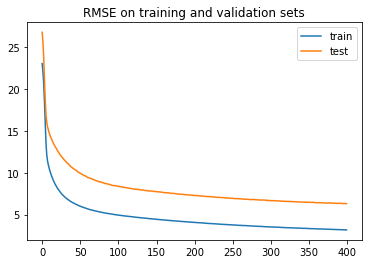

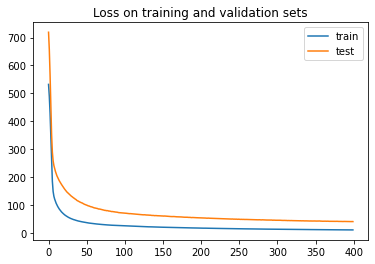

In [10]:
# Build model
model_2.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.001),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics = [tf.keras.metrics.RootMeanSquaredError(), R2])

# Train model
history = model_2.fit(x, y_train, epochs=400, batch_size=64, validation_split=0.2, verbose=1)

# Plot RMSE
plt.figure(3)
plt.plot(history.history['root_mean_squared_error'],label='train')
plt.plot(history.history['val_root_mean_squared_error'],label='test')
plt.legend()
plt.title('RMSE on training and validation sets')
plt.show()

# Plot MSE
plt.figure(4)
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.title('Loss on training and validation sets')
plt.show()

### Predict with the model

In [11]:
# Pass test data through the kernels
x = pairwise.rbf_kernel(x_test, Y=centers, gamma=np.float32(1/(2*var)))

# Metrics for the test set
scores = model_2.evaluate(x,y_test, verbose=0)

print('For the test set:')
print('R2: {}'.format(scores[2]))
print('RMSE: {}'.format(scores[1]))

For the test set:
R2: 0.5677101016044617
RMSE: 5.596317291259766


### Model 3: Number of kernels = 0.9 * number of training samples

### Calculate the centers and variance for the kernels using the K-Means algorithm

In [12]:
# Number of kernels in hidden layer
num_centers = int(0.9*x_train.shape[0])

# Centers of the kernels
kmeans = KMeans(n_clusters=num_centers, init='k-means++', n_init=10, verbose=0).fit(x_train)
centers = kmeans.cluster_centers_

# Variance of each kernel
dists = pdist(centers, metric='euclidean')
d_max = np.amax(dists)
var = d_max / tf.math.sqrt(2*float(centers.shape[0]))

# Pass training data through the kernels
x = pairwise.rbf_kernel(x_train, Y=centers, gamma=np.float32(1/(2*var)))

### Create the output layer

In [13]:
# The model contains the output layer and its input is the output of the hidden layer
model_3 = models.Sequential()

# Output layer
model_3.add(layers.Dense(128, activation='relu', input_shape=(x.shape[1],),
                         kernel_initializer=initializers.LecunNormal()))

model_3.add(layers.Dense(1, activation='relu',
                         kernel_initializer=initializers.LecunNormal()))

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               43776     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 43,905
Trainable params: 43,905
Non-trainable params: 0
_________________________________________________________________


### Train the model

Epoch 1/400
5/5 [==============================] - 0s 40ms/step - loss: 539.0661 - root_mean_squared_error: 23.2178 - R2: -6.5295 - val_loss: 736.1407 - val_root_mean_squared_error: 27.1319 - val_R2: -8.9015
Epoch 2/400
5/5 [==============================] - 0s 11ms/step - loss: 508.6346 - root_mean_squared_error: 22.5529 - R2: -5.7733 - val_loss: 692.4613 - val_root_mean_squared_error: 26.3147 - val_R2: -8.1683
Epoch 3/400
5/5 [==============================] - 0s 11ms/step - loss: 464.9741 - root_mean_squared_error: 21.5633 - R2: -5.2401 - val_loss: 627.3679 - val_root_mean_squared_error: 25.0473 - val_R2: -7.0672
Epoch 4/400
5/5 [==============================] - 0s 10ms/step - loss: 401.3521 - root_mean_squared_error: 20.0338 - R2: -4.2729 - val_loss: 535.6982 - val_root_mean_squared_error: 23.1452 - val_R2: -5.5216
Epoch 5/400
5/5 [==============================] - 0s 8ms/step - loss: 319.5049 - root_mean_squared_error: 17.8747 - R2: -3.2144 - val_loss: 432.3217 - val_root_mean_sq

Epoch 41/400
5/5 [==============================] - 0s 10ms/step - loss: 36.5145 - root_mean_squared_error: 6.0427 - R2: 0.5250 - val_loss: 100.7792 - val_root_mean_squared_error: 10.0389 - val_R2: 0.2088
Epoch 42/400
5/5 [==============================] - 0s 9ms/step - loss: 35.9329 - root_mean_squared_error: 5.9944 - R2: 0.5310 - val_loss: 100.4221 - val_root_mean_squared_error: 10.0211 - val_R2: 0.2229
Epoch 43/400
5/5 [==============================] - 0s 9ms/step - loss: 35.2379 - root_mean_squared_error: 5.9362 - R2: 0.5321 - val_loss: 98.6432 - val_root_mean_squared_error: 9.9319 - val_R2: 0.2361
Epoch 44/400
5/5 [==============================] - 0s 10ms/step - loss: 34.6798 - root_mean_squared_error: 5.8890 - R2: 0.5647 - val_loss: 97.1647 - val_root_mean_squared_error: 9.8572 - val_R2: 0.2486
Epoch 45/400
5/5 [==============================] - 0s 9ms/step - loss: 34.1709 - root_mean_squared_error: 5.8456 - R2: 0.5508 - val_loss: 96.0747 - val_root_mean_squared_error: 9.8018 -

5/5 [==============================] - 0s 9ms/step - loss: 24.7022 - root_mean_squared_error: 4.9701 - R2: 0.6759 - val_loss: 74.2830 - val_root_mean_squared_error: 8.6188 - val_R2: 0.4688
Epoch 82/400
5/5 [==============================] - 0s 10ms/step - loss: 24.4307 - root_mean_squared_error: 4.9427 - R2: 0.7032 - val_loss: 73.9278 - val_root_mean_squared_error: 8.5981 - val_R2: 0.4712
Epoch 83/400
5/5 [==============================] - 0s 9ms/step - loss: 24.2998 - root_mean_squared_error: 4.9295 - R2: 0.6906 - val_loss: 73.2913 - val_root_mean_squared_error: 8.5610 - val_R2: 0.4732
Epoch 84/400
5/5 [==============================] - 0s 10ms/step - loss: 24.2130 - root_mean_squared_error: 4.9207 - R2: 0.6973 - val_loss: 73.1785 - val_root_mean_squared_error: 8.5544 - val_R2: 0.4768
Epoch 85/400
5/5 [==============================] - 0s 9ms/step - loss: 24.0273 - root_mean_squared_error: 4.9018 - R2: 0.6806 - val_loss: 72.6645 - val_root_mean_squared_error: 8.5243 - val_R2: 0.4783
E

5/5 [==============================] - 0s 10ms/step - loss: 20.1198 - root_mean_squared_error: 4.4855 - R2: 0.7429 - val_loss: 64.8499 - val_root_mean_squared_error: 8.0529 - val_R2: 0.5411
Epoch 122/400
5/5 [==============================] - 0s 10ms/step - loss: 19.9815 - root_mean_squared_error: 4.4701 - R2: 0.7517 - val_loss: 64.8093 - val_root_mean_squared_error: 8.0504 - val_R2: 0.5421
Epoch 123/400
5/5 [==============================] - 0s 9ms/step - loss: 19.9156 - root_mean_squared_error: 4.4627 - R2: 0.7453 - val_loss: 64.2682 - val_root_mean_squared_error: 8.0167 - val_R2: 0.5440
Epoch 124/400
5/5 [==============================] - 0s 10ms/step - loss: 19.8440 - root_mean_squared_error: 4.4547 - R2: 0.7479 - val_loss: 64.6133 - val_root_mean_squared_error: 8.0382 - val_R2: 0.5442
Epoch 125/400
5/5 [==============================] - 0s 9ms/step - loss: 19.7683 - root_mean_squared_error: 4.4462 - R2: 0.7492 - val_loss: 63.9936 - val_root_mean_squared_error: 7.9996 - val_R2: 0.5

5/5 [==============================] - 0s 10ms/step - loss: 16.8671 - root_mean_squared_error: 4.1070 - R2: 0.7812 - val_loss: 58.4360 - val_root_mean_squared_error: 7.6443 - val_R2: 0.5846
Epoch 162/400
5/5 [==============================] - 0s 10ms/step - loss: 16.8039 - root_mean_squared_error: 4.0993 - R2: 0.7769 - val_loss: 58.3360 - val_root_mean_squared_error: 7.6378 - val_R2: 0.5855
Epoch 163/400
5/5 [==============================] - 0s 9ms/step - loss: 16.7443 - root_mean_squared_error: 4.0920 - R2: 0.7835 - val_loss: 58.1040 - val_root_mean_squared_error: 7.6226 - val_R2: 0.5866
Epoch 164/400
5/5 [==============================] - 0s 9ms/step - loss: 16.6322 - root_mean_squared_error: 4.0783 - R2: 0.7840 - val_loss: 58.1351 - val_root_mean_squared_error: 7.6246 - val_R2: 0.5871
Epoch 165/400
5/5 [==============================] - 0s 8ms/step - loss: 16.6395 - root_mean_squared_error: 4.0792 - R2: 0.7934 - val_loss: 57.8891 - val_root_mean_squared_error: 7.6085 - val_R2: 0.58

5/5 [==============================] - 0s 10ms/step - loss: 14.3615 - root_mean_squared_error: 3.7897 - R2: 0.8076 - val_loss: 53.3626 - val_root_mean_squared_error: 7.3050 - val_R2: 0.6154
Epoch 202/400
5/5 [==============================] - 0s 10ms/step - loss: 14.2979 - root_mean_squared_error: 3.7813 - R2: 0.8157 - val_loss: 53.0956 - val_root_mean_squared_error: 7.2867 - val_R2: 0.6172
Epoch 203/400
5/5 [==============================] - 0s 10ms/step - loss: 14.3481 - root_mean_squared_error: 3.7879 - R2: 0.8113 - val_loss: 53.0933 - val_root_mean_squared_error: 7.2865 - val_R2: 0.6176
Epoch 204/400
5/5 [==============================] - 0s 9ms/step - loss: 14.3053 - root_mean_squared_error: 3.7822 - R2: 0.8210 - val_loss: 53.2106 - val_root_mean_squared_error: 7.2946 - val_R2: 0.6167
Epoch 205/400
5/5 [==============================] - 0s 10ms/step - loss: 14.1665 - root_mean_squared_error: 3.7638 - R2: 0.8249 - val_loss: 52.7623 - val_root_mean_squared_error: 7.2638 - val_R2: 0.

5/5 [==============================] - 0s 9ms/step - loss: 12.3891 - root_mean_squared_error: 3.5198 - R2: 0.8435 - val_loss: 49.2101 - val_root_mean_squared_error: 7.0150 - val_R2: 0.6386
Epoch 242/400
5/5 [==============================] - 0s 9ms/step - loss: 12.3576 - root_mean_squared_error: 3.5153 - R2: 0.8503 - val_loss: 48.9147 - val_root_mean_squared_error: 6.9939 - val_R2: 0.6400
Epoch 243/400
5/5 [==============================] - 0s 10ms/step - loss: 12.3397 - root_mean_squared_error: 3.5128 - R2: 0.8370 - val_loss: 48.9689 - val_root_mean_squared_error: 6.9978 - val_R2: 0.6395
Epoch 244/400
5/5 [==============================] - 0s 8ms/step - loss: 12.2398 - root_mean_squared_error: 3.4985 - R2: 0.8400 - val_loss: 48.7229 - val_root_mean_squared_error: 6.9802 - val_R2: 0.6408
Epoch 245/400
5/5 [==============================] - 0s 9ms/step - loss: 12.2884 - root_mean_squared_error: 3.5055 - R2: 0.8403 - val_loss: 48.7434 - val_root_mean_squared_error: 6.9816 - val_R2: 0.642

5/5 [==============================] - 0s 10ms/step - loss: 10.7834 - root_mean_squared_error: 3.2838 - R2: 0.8556 - val_loss: 45.6518 - val_root_mean_squared_error: 6.7566 - val_R2: 0.6564
Epoch 282/400
5/5 [==============================] - 0s 9ms/step - loss: 10.7403 - root_mean_squared_error: 3.2772 - R2: 0.8619 - val_loss: 45.4836 - val_root_mean_squared_error: 6.7442 - val_R2: 0.6571
Epoch 283/400
5/5 [==============================] - 0s 9ms/step - loss: 10.6743 - root_mean_squared_error: 3.2672 - R2: 0.8630 - val_loss: 45.3598 - val_root_mean_squared_error: 6.7350 - val_R2: 0.6575
Epoch 284/400
5/5 [==============================] - 0s 9ms/step - loss: 10.6530 - root_mean_squared_error: 3.2639 - R2: 0.8604 - val_loss: 45.3825 - val_root_mean_squared_error: 6.7367 - val_R2: 0.6575
Epoch 285/400
5/5 [==============================] - 0s 9ms/step - loss: 10.6582 - root_mean_squared_error: 3.2647 - R2: 0.8639 - val_loss: 45.0795 - val_root_mean_squared_error: 6.7141 - val_R2: 0.659

5/5 [==============================] - 0s 10ms/step - loss: 9.5194 - root_mean_squared_error: 3.0853 - R2: 0.8842 - val_loss: 42.8727 - val_root_mean_squared_error: 6.5477 - val_R2: 0.6703
Epoch 322/400
5/5 [==============================] - 0s 10ms/step - loss: 9.5696 - root_mean_squared_error: 3.0935 - R2: 0.8719 - val_loss: 43.0610 - val_root_mean_squared_error: 6.5621 - val_R2: 0.6688
Epoch 323/400
5/5 [==============================] - 0s 9ms/step - loss: 9.4991 - root_mean_squared_error: 3.0821 - R2: 0.8793 - val_loss: 42.6221 - val_root_mean_squared_error: 6.5286 - val_R2: 0.6720
Epoch 324/400
5/5 [==============================] - 0s 9ms/step - loss: 9.4729 - root_mean_squared_error: 3.0778 - R2: 0.8742 - val_loss: 42.5620 - val_root_mean_squared_error: 6.5240 - val_R2: 0.6722
Epoch 325/400
5/5 [==============================] - 0s 9ms/step - loss: 9.4191 - root_mean_squared_error: 3.0691 - R2: 0.8784 - val_loss: 42.3762 - val_root_mean_squared_error: 6.5097 - val_R2: 0.6725
Ep

5/5 [==============================] - 0s 10ms/step - loss: 8.5392 - root_mean_squared_error: 2.9222 - R2: 0.8957 - val_loss: 40.5220 - val_root_mean_squared_error: 6.3657 - val_R2: 0.6802
Epoch 362/400
5/5 [==============================] - 0s 10ms/step - loss: 8.4932 - root_mean_squared_error: 2.9143 - R2: 0.8897 - val_loss: 40.5198 - val_root_mean_squared_error: 6.3655 - val_R2: 0.6810
Epoch 363/400
5/5 [==============================] - 0s 9ms/step - loss: 8.4478 - root_mean_squared_error: 2.9065 - R2: 0.8837 - val_loss: 40.6835 - val_root_mean_squared_error: 6.3784 - val_R2: 0.6797
Epoch 364/400
5/5 [==============================] - 0s 10ms/step - loss: 8.4726 - root_mean_squared_error: 2.9108 - R2: 0.8935 - val_loss: 40.4772 - val_root_mean_squared_error: 6.3622 - val_R2: 0.6802
Epoch 365/400
5/5 [==============================] - 0s 11ms/step - loss: 8.4364 - root_mean_squared_error: 2.9046 - R2: 0.8921 - val_loss: 40.4628 - val_root_mean_squared_error: 6.3610 - val_R2: 0.6805


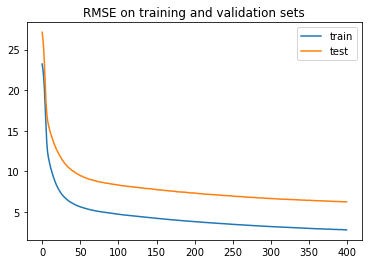

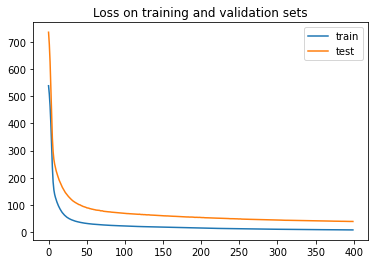

In [14]:
# Build model
model_3.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.001),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics = [tf.keras.metrics.RootMeanSquaredError(), R2])

# Train model
history = model_3.fit(x, y_train, epochs=400, batch_size=64, validation_split=0.2, verbose=1)

# Plot RMSE
plt.figure(5)
plt.plot(history.history['root_mean_squared_error'],label='train')
plt.plot(history.history['val_root_mean_squared_error'],label='test')
plt.legend()
plt.title('RMSE on training and validation sets')
plt.show()

# Plot MSE
plt.figure(6)
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.title('Loss on training and validation sets')
plt.show()

### Predict with the model

In [15]:
# Pass test data through the kernels
x = pairwise.rbf_kernel(x_test, Y=centers, gamma=np.float32(1/(2*var)))

# Metrics for the test set
scores = model_3.evaluate(x,y_test, verbose=0)

print('For the test set:')
print('R2: {}'.format(scores[2]))
print('RMSE: {}'.format(scores[1]))

For the test set:
R2: 0.6046677827835083
RMSE: 5.396848201751709


## Part 2: Fine-tuning of an RBF model

In [16]:
# 5-fold cross-validation to choose the optimal model
kfold = KFold(n_splits=5, shuffle=True)

# 1st hyperparameter: Number of kernels in hidden layer
num_centers = np.array([int(0.05*x_train.shape[0]), int(0.15*x_train.shape[0]),
                        int(0.3*x_train.shape[0]), int(0.5*x_train.shape[0])])

# 2nd hyperparameter: Number of neurons in output layer
output_units = np.array([32, 64, 128, 256])

# 3rd hyperparameter: probability of dropout in output layer
dropout_p = np.array([0.2, 0.35, 0.5])

### Apply 5-fold cross-validation for each model to choose the optimal

In [17]:
# This block needs 5-10 minutes to be executed

mse_per_fold = np.zeros(5)
rmse_per_fold = np.zeros(5)

best_rmse = float('inf')
best_num_centers = None
best_output_units = None
best_dropout_p = None
best_mse = None
best_x = None
best_centers = None

model_no = 1

for i in num_centers:
    
    # Centers of hidden layer
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, verbose=0).fit(x_train)
    centers = kmeans.cluster_centers_
    
    # Variance for each kernel
    dists = pdist(centers, metric='euclidean')
    d_max = np.amax(dists)
    var = d_max / tf.math.sqrt(2*float(centers.shape[0]))
    
    # Pass all training data through the kernels
    x = pairwise.rbf_kernel(x_train, Y=centers, gamma=np.float32(1/(2*var)))
    
    for j in output_units:
        for k in dropout_p:
            fold_no = 0
            
            for train, test in kfold.split(x, y_train):
                
                # Create output layer
                model = models.Sequential()
                model.add(layers.Dense(j,activation='relu', input_shape=(x.shape[1],),
                                       kernel_initializer=initializers.LecunNormal()))
                model.add(layers.Dropout(k))
                model.add(layers.Dense(1, activation='relu',
                         kernel_initializer=initializers.LecunNormal()))
                
                # Build model
                model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.001),
                      loss = tf.keras.losses.MeanSquaredError(),
                      metrics = [tf.keras.metrics.RootMeanSquaredError()])
                
                #Early stopping
                stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'root_mean_squared_error',
                                                              mode = 'min',
                                                              patience = 20,
                                                              verbose=0)
                
                # Train model
                model.fit(x[train],y_train[train], epochs=100, batch_size=64, callbacks = [stop_early], verbose=0)
                
                # Evaluate model in validation set
                scores = model.evaluate(x[test],y_train[test], verbose=0)
                mse_per_fold[fold_no] = scores[0]
                rmse_per_fold[fold_no] = scores[1]
                
                fold_no += 1
            
            # Mean of RMSE and MSE for 5-fold cross-validation of a specific model
            rmse = np.mean(rmse_per_fold)
            mse = np.mean(mse_per_fold)
            
            print('Model {}:'.format(model_no))
            print('Number of kernels: {}'.format(i))
            print('Neurons in output layer: {}'.format(j))
            print('p = {}'.format(k))
            print('RMSE: {}'.format(rmse))
            print('MSE: {}\n'.format(mse))
            
            model_no += 1
            
            # Choose best model based on its RMSE
            if(rmse < best_rmse):
                best_rmse = rmse
                best_mse = mse
                best_num_centers = i
                best_output_units = j
                best_dropout_p = k
                best_x = x
                best_centers = centers
        
print('Optimal parameters for the model:')
print('Number of kernels: {}'.format(best_num_centers))
print('Neurons in output layer: {}'.format(best_output_units))
print('p = {}'.format(best_dropout_p))

print('RMSE: {}'.format(best_rmse))
print('MSE: {}'.format(best_mse))

Model 1:
Number of kernels: 18
Neurons in output layer: 32
p = 0.2
RMSE: 7.212022209167481
MSE: 53.395195388793944

Model 2:
Number of kernels: 18
Neurons in output layer: 32
p = 0.35
RMSE: 7.309613132476807
MSE: 53.8700309753418

Model 3:
Number of kernels: 18
Neurons in output layer: 32
p = 0.5
RMSE: 7.48834228515625
MSE: 58.77463836669922

Model 4:
Number of kernels: 18
Neurons in output layer: 64
p = 0.2
RMSE: 7.216004943847656
MSE: 53.25014762878418

Model 5:
Number of kernels: 18
Neurons in output layer: 64
p = 0.35
RMSE: 7.158237171173096
MSE: 52.638604736328126

Model 6:
Number of kernels: 18
Neurons in output layer: 64
p = 0.5
RMSE: 7.163801383972168
MSE: 55.01100540161133

Model 7:
Number of kernels: 18
Neurons in output layer: 128
p = 0.2
RMSE: 7.128268909454346
MSE: 51.656470489501956

Model 8:
Number of kernels: 18
Neurons in output layer: 128
p = 0.35
RMSE: 7.121924972534179
MSE: 51.85652084350586

Model 9:
Number of kernels: 18
Neurons in output layer: 128
p = 0.5
RMSE: 

### Train optimal model

### Create the output layer

In [18]:
# The model contains the output layer and its input is the output of the hidden layer
opt_model = models.Sequential()
opt_model.add(layers.Dense(best_output_units,activation='relu', input_shape=(x.shape[1],),
                           kernel_initializer=initializers.LecunNormal()))
opt_model.add(layers.Dropout(best_dropout_p))

# Output layer
opt_model.add(layers.Dense(1, activation='relu',
                         kernel_initializer=initializers.LecunNormal()))

### Train the model

Epoch 1/400
5/5 [==============================] - 0s 34ms/step - loss: 541.1472 - root_mean_squared_error: 23.2626 - val_loss: 727.3341 - val_root_mean_squared_error: 26.9691
Epoch 2/400
5/5 [==============================] - 0s 10ms/step - loss: 494.8013 - root_mean_squared_error: 22.2441 - val_loss: 659.8710 - val_root_mean_squared_error: 25.6880
Epoch 3/400
5/5 [==============================] - 0s 7ms/step - loss: 428.9771 - root_mean_squared_error: 20.7118 - val_loss: 568.4033 - val_root_mean_squared_error: 23.8412
Epoch 4/400
5/5 [==============================] - 0s 7ms/step - loss: 346.0900 - root_mean_squared_error: 18.6035 - val_loss: 458.5224 - val_root_mean_squared_error: 21.4131
Epoch 5/400
5/5 [==============================] - 0s 7ms/step - loss: 258.9703 - root_mean_squared_error: 16.0926 - val_loss: 359.8473 - val_root_mean_squared_error: 18.9696
Epoch 6/400
5/5 [==============================] - 0s 7ms/step - loss: 193.9697 - root_mean_squared_error: 13.9273 - val_lo

Epoch 48/400
5/5 [==============================] - 0s 7ms/step - loss: 41.5309 - root_mean_squared_error: 6.4444 - val_loss: 104.2893 - val_root_mean_squared_error: 10.2122
Epoch 49/400
5/5 [==============================] - 0s 7ms/step - loss: 38.9471 - root_mean_squared_error: 6.2408 - val_loss: 102.8404 - val_root_mean_squared_error: 10.1410
Epoch 50/400
5/5 [==============================] - 0s 7ms/step - loss: 38.9957 - root_mean_squared_error: 6.2447 - val_loss: 102.8812 - val_root_mean_squared_error: 10.1430
Epoch 51/400
5/5 [==============================] - 0s 9ms/step - loss: 38.4759 - root_mean_squared_error: 6.2029 - val_loss: 101.0127 - val_root_mean_squared_error: 10.0505
Epoch 52/400
5/5 [==============================] - 0s 7ms/step - loss: 39.8863 - root_mean_squared_error: 6.3156 - val_loss: 100.3574 - val_root_mean_squared_error: 10.0179
Epoch 53/400
5/5 [==============================] - 0s 8ms/step - loss: 38.6692 - root_mean_squared_error: 6.2185 - val_loss: 99.2

5/5 [==============================] - 0s 8ms/step - loss: 27.2376 - root_mean_squared_error: 5.2190 - val_loss: 73.0679 - val_root_mean_squared_error: 8.5480
Epoch 96/400
5/5 [==============================] - 0s 8ms/step - loss: 30.4754 - root_mean_squared_error: 5.5204 - val_loss: 72.9645 - val_root_mean_squared_error: 8.5419
Epoch 97/400
5/5 [==============================] - 0s 8ms/step - loss: 26.7617 - root_mean_squared_error: 5.1732 - val_loss: 72.8244 - val_root_mean_squared_error: 8.5337
Epoch 98/400
5/5 [==============================] - 0s 8ms/step - loss: 26.8023 - root_mean_squared_error: 5.1771 - val_loss: 73.1640 - val_root_mean_squared_error: 8.5536
Epoch 99/400
5/5 [==============================] - 0s 7ms/step - loss: 26.1482 - root_mean_squared_error: 5.1135 - val_loss: 72.3918 - val_root_mean_squared_error: 8.5083
Epoch 100/400
5/5 [==============================] - 0s 8ms/step - loss: 27.2094 - root_mean_squared_error: 5.2163 - val_loss: 71.4667 - val_root_mean_sq

5/5 [==============================] - 0s 8ms/step - loss: 22.0071 - root_mean_squared_error: 4.6912 - val_loss: 61.8242 - val_root_mean_squared_error: 7.8628
Epoch 143/400
5/5 [==============================] - 0s 7ms/step - loss: 21.4061 - root_mean_squared_error: 4.6267 - val_loss: 61.7735 - val_root_mean_squared_error: 7.8596
Epoch 144/400
5/5 [==============================] - 0s 7ms/step - loss: 22.1679 - root_mean_squared_error: 4.7083 - val_loss: 61.9203 - val_root_mean_squared_error: 7.8689
Epoch 145/400
5/5 [==============================] - 0s 8ms/step - loss: 23.0633 - root_mean_squared_error: 4.8024 - val_loss: 60.8797 - val_root_mean_squared_error: 7.8025
Epoch 146/400
5/5 [==============================] - 0s 7ms/step - loss: 22.1335 - root_mean_squared_error: 4.7046 - val_loss: 61.2392 - val_root_mean_squared_error: 7.8256
Epoch 147/400
5/5 [==============================] - 0s 8ms/step - loss: 22.4223 - root_mean_squared_error: 4.7352 - val_loss: 61.5589 - val_root_mea

5/5 [==============================] - 0s 7ms/step - loss: 18.8320 - root_mean_squared_error: 4.3396 - val_loss: 55.1030 - val_root_mean_squared_error: 7.4231
Epoch 190/400
5/5 [==============================] - 0s 7ms/step - loss: 19.9377 - root_mean_squared_error: 4.4652 - val_loss: 54.8494 - val_root_mean_squared_error: 7.4060
Epoch 191/400
5/5 [==============================] - 0s 7ms/step - loss: 18.2648 - root_mean_squared_error: 4.2737 - val_loss: 54.5280 - val_root_mean_squared_error: 7.3843
Epoch 192/400
5/5 [==============================] - 0s 7ms/step - loss: 20.2271 - root_mean_squared_error: 4.4975 - val_loss: 54.5303 - val_root_mean_squared_error: 7.3845
Epoch 193/400
5/5 [==============================] - 0s 7ms/step - loss: 19.8057 - root_mean_squared_error: 4.4504 - val_loss: 54.6043 - val_root_mean_squared_error: 7.3895
Epoch 194/400
5/5 [==============================] - 0s 7ms/step - loss: 19.3239 - root_mean_squared_error: 4.3959 - val_loss: 54.1305 - val_root_mea

5/5 [==============================] - 0s 6ms/step - loss: 15.1380 - root_mean_squared_error: 3.8908 - val_loss: 49.2108 - val_root_mean_squared_error: 7.0150
Epoch 237/400
5/5 [==============================] - 0s 8ms/step - loss: 16.1498 - root_mean_squared_error: 4.0187 - val_loss: 49.7305 - val_root_mean_squared_error: 7.0520
Epoch 238/400
5/5 [==============================] - 0s 7ms/step - loss: 15.8352 - root_mean_squared_error: 3.9794 - val_loss: 49.6022 - val_root_mean_squared_error: 7.0429
Epoch 239/400
5/5 [==============================] - 0s 7ms/step - loss: 16.5776 - root_mean_squared_error: 4.0716 - val_loss: 49.2250 - val_root_mean_squared_error: 7.0161
Epoch 240/400
5/5 [==============================] - 0s 7ms/step - loss: 16.2711 - root_mean_squared_error: 4.0337 - val_loss: 48.8385 - val_root_mean_squared_error: 6.9885
Epoch 241/400
5/5 [==============================] - 0s 7ms/step - loss: 16.7694 - root_mean_squared_error: 4.0950 - val_loss: 48.5353 - val_root_mea

5/5 [==============================] - 0s 7ms/step - loss: 15.7790 - root_mean_squared_error: 3.9723 - val_loss: 44.8383 - val_root_mean_squared_error: 6.6961
Epoch 284/400
5/5 [==============================] - 0s 7ms/step - loss: 14.7989 - root_mean_squared_error: 3.8469 - val_loss: 45.1515 - val_root_mean_squared_error: 6.7195
Epoch 285/400
5/5 [==============================] - 0s 7ms/step - loss: 14.5487 - root_mean_squared_error: 3.8143 - val_loss: 44.8641 - val_root_mean_squared_error: 6.6981
Epoch 286/400
5/5 [==============================] - 0s 8ms/step - loss: 14.7207 - root_mean_squared_error: 3.8368 - val_loss: 44.6255 - val_root_mean_squared_error: 6.6802
Epoch 287/400
5/5 [==============================] - 0s 7ms/step - loss: 15.0851 - root_mean_squared_error: 3.8839 - val_loss: 44.6962 - val_root_mean_squared_error: 6.6855
Epoch 288/400
5/5 [==============================] - 0s 7ms/step - loss: 13.2833 - root_mean_squared_error: 3.6446 - val_loss: 44.4946 - val_root_mea

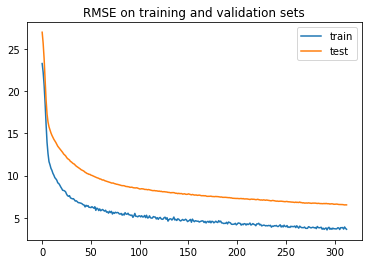

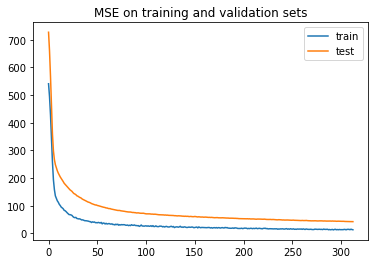

In [19]:
# Build model
opt_model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.001),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics = [tf.keras.metrics.RootMeanSquaredError()])

# Train model
history = opt_model.fit(best_x, y_train, epochs=400, batch_size=64, validation_split = 0.2, callbacks = [stop_early], verbose=1)

# Plot RMSE
plt.figure(7)
plt.plot(history.history['root_mean_squared_error'],label='train')
plt.plot(history.history['val_root_mean_squared_error'],label='test')
plt.legend()
plt.title('RMSE on training and validation sets')
plt.show()

# Plot MSE
plt.figure(8)
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.title('MSE on training and validation sets')
plt.show()

### Evaluate on test set

In [20]:
# Pass test data through the kernels
x = pairwise.rbf_kernel(x_test, Y=centers, gamma=np.float32(1/(2*var)))

# Metrics for the test set
scores = opt_model.evaluate(x,y_test, verbose=1)

print('For the test set:')
print('MSE: {}'.format(scores[0]))
print('RMSE: {}'.format(scores[1]))

4/4 [==============================] - 0s 3ms/step - loss: 29.1545 - root_mean_squared_error: 5.3995
For the test set:
MSE: 29.154516220092773
RMSE: 5.399492263793945
